In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np 
import pandas as pd
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [3]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset3/"

# Data preparation

## SC data

#### Data reading

In [4]:
# Read csvs
genes = pd.read_csv(f"{data_path}GSE113576/genes.tsv.gz", sep='\t', header=None, names=["gene_id", "gene_name"])
cells = pd.read_csv(f"{data_path}GSE113576/barcodes.tsv.gz", sep='\t', header=None, names=["barcode"])

In [5]:
from scipy.io import mmread

# Read counts
X = mmread(f"{data_path}GSE113576/matrix.mtx.gz").T.tocsr()  # sparse matrix

In [6]:
# Create adata
adata_sc = ad.AnnData(X=X)
adata_sc.var["gene_ids"] = genes["gene_id"].values
adata_sc.var_names = genes["gene_name"].values
adata_sc.obs_names = cells["barcode"].values
adata_sc

AnnData object with n_obs × n_vars = 31299 × 27998
    var: 'gene_ids'

The number of cell matches the bechmarking, while the number of genes in the paper is restricetd to $18646$ wrt to the original $27998$.

Any type of annotation is missing, including cell type and counts are raw.

#### Counts inspection

In [5]:
# Inspect basic stats
X = adata_sc.X
if not isinstance(X, np.ndarray):
    X = X.toarray()  # if sparse

pd.Series(X.ravel()).describe()

count    8.763094e+08
mean     2.479331e-01
std      3.616676e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.959000e+03
dtype: float64

In [6]:
# Check if all values are integers
is_integer = np.allclose(X, np.round(X))
print("All integer values:", is_integer)

All integer values: True


#### Filter empty/doublets
We empirically remove candidate empty droplets and doublets by filtering out the 5th and 95th percentiles of the total counts per cell distribution:

1519.96 20893.220000000005


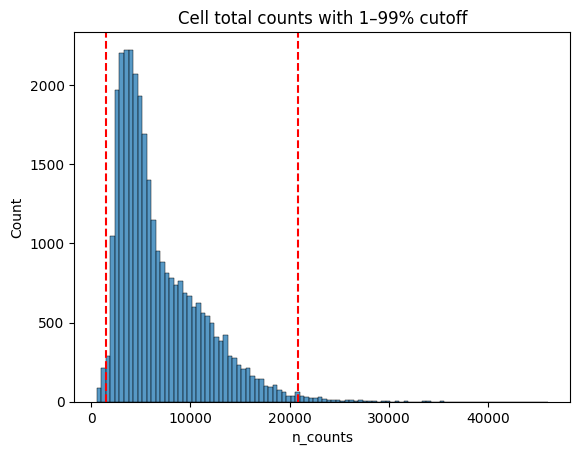

In [8]:
# compute n counts per cell
adata_sc.obs['n_counts'] = np.array(adata_sc.X.sum(axis=1)).ravel()
# compute 5th and 95th percentiles
low, high = np.percentile(adata_sc.obs['n_counts'], [1, 99])
print(low, high)
# plot distribution
sns.histplot(adata_sc.obs['n_counts'], bins=100)
plt.axvline(low, color='red', linestyle='--')
plt.axvline(high, color='red', linestyle='--')
plt.title('Cell total counts with 1–99% cutoff')
plt.show()

In [9]:
print("numebr of empty cells = ", (adata_sc.X.sum(axis=1) == 0).sum())

numebr of empty cells =  0


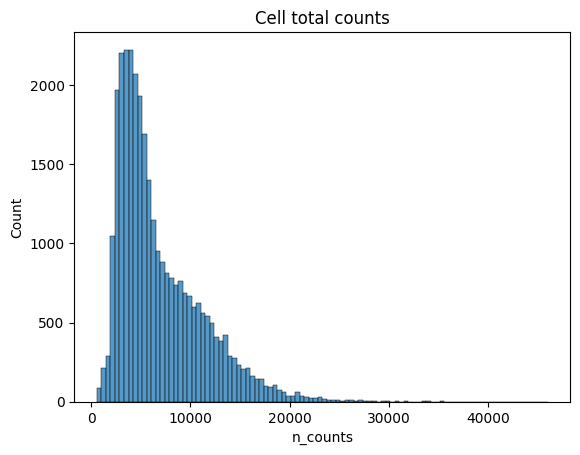

In [10]:
# plot distribution
sns.histplot(adata_sc.obs['n_counts'], bins=100)
plt.title('Cell total counts')
plt.show()

Clearly, doublets and empty cell have been removed already.

#### Filter genes

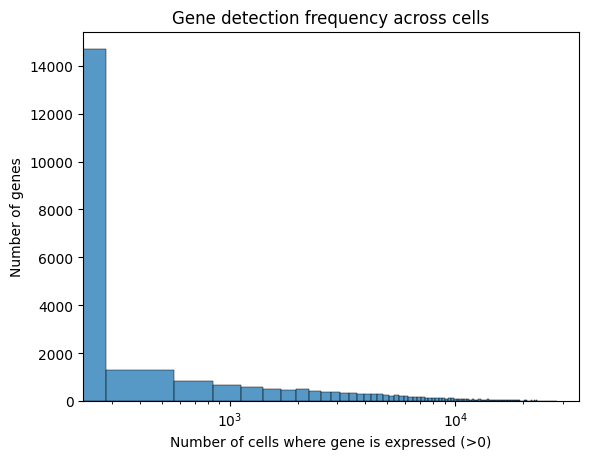

In [9]:
# compute counts if not already done
if 'n_cells_expressed' not in adata_sc.var.columns:
    adata_sc.var['n_cells_expressed'] = np.array((adata_sc.X > 0).sum(axis=0)).ravel()

# histogram (log scale on x is clearer)
sns.histplot(adata_sc.var['n_cells_expressed'], bins=100)
plt.xscale('log')
plt.xlabel('Number of cells where gene is expressed (>0)')
plt.ylabel('Number of genes')
plt.title('Gene detection frequency across cells')
plt.show()

[ 211. 3796.]


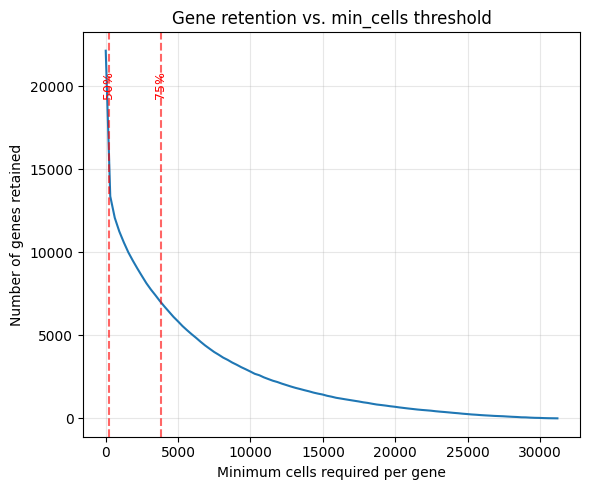

In [11]:
adata_sc.var['n_cells_expressed'] = np.array((adata_sc.X > 0).sum(axis=0)).ravel()
freq = adata_sc.var['n_cells_expressed'] / adata_sc.shape[0]
n_cells = adata_sc.shape[0]
n_cells_expr = adata_sc.var['n_cells_expressed'].to_numpy()

# thresholds for min_cells
thresholds = np.arange(1, n_cells + 1, int(n_cells / 100))
genes_kept = [(n_cells_expr >= t).sum() for t in thresholds]

# quantiles of gene expression counts
quantiles = np.quantile(n_cells_expr, [0.5, 0.75])
print(quantiles)

plt.figure(figsize=(6,5))
plt.plot(thresholds, genes_kept, label='Genes retained')
for q, label in zip(quantiles, ['50%', '75%']):
    plt.axvline(q, color='r', linestyle='--', alpha=0.6)
    plt.text(q, plt.ylim()[1]*0.9, label, rotation=90, color='r',
             ha='center', va='top', fontsize=9)

plt.xlabel('Minimum cells required per gene')
plt.ylabel('Number of genes retained')
plt.title('Gene retention vs. min_cells threshold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
low_genes = np.percentile(adata_sc.var['n_cells_expressed'], 30)
low_genes    

np.float64(5.0)

Here with 5 we are already at the 30-th percentile, we do 4...

In [15]:
# remove all genes not expressed in any cell
sc.pp.filter_genes(adata_sc, min_cells=4)
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 31299 × 19980
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells_expressed', 'n_cells'

#### Normalization
CP10K and log1p:

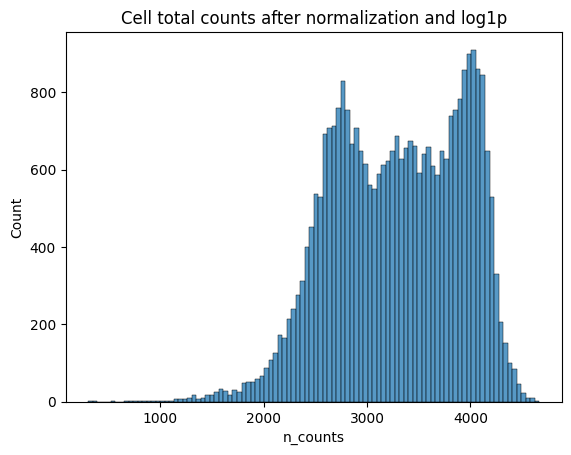

In [16]:
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)
# update counts
adata_sc.obs['n_counts'] = np.array(adata_sc.X.sum(axis=1)).ravel()

sns.histplot(adata_sc.obs['n_counts'], bins=100)
plt.title('Cell total counts after normalization and log1p')
plt.show()

In [25]:
X = adata_sc.X
if not isinstance(X, np.ndarray):
    X = X.toarray()  # if sparse

pd.Series(X.ravel()).describe()

count    6.253540e+08
mean     1.647690e-01
std      4.726380e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.699681e+00
dtype: float64

#### Sparsity
Annotate total sparsity:

In [17]:
## add sparsity in uns
# handle sparse or dense automatically
X = adata_sc.X
if not isinstance(X, np.ndarray):
    X = X.copy()  # ensures .count_nonzero() works

# compute sparsity = fraction of zero entries
n_total = np.prod(adata_sc.shape)
n_nonzero = X.count_nonzero() if hasattr(X, "count_nonzero") else np.count_nonzero(X)
sparsity = 1 - (n_nonzero / n_total)

adata_sc.uns["sparsity"] = float(sparsity)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.8651


#### HVGs

In [18]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=2000,
    flavor='seurat_v3'
)
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 31299 × 19980
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells_expressed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'sparsity', 'hvg'

#### Save

In [19]:
# Save h5ad
sc.write(data_path + "scRNA_data.h5ad", adata_sc, "h5ad")

/tmp/ipykernel_1176341/2811045455.py:2: FutureWarning: The specified parameters ('ext',) are no longer positional. Please specify them like `ext='h5ad'`
  sc.write(data_path + "scRNA_data.h5ad", adata_sc, "h5ad")


## MERFISH data

#### Data reading
The csv file contains, in a single dataframe, cell metadata and counts per gene all organized as columns, thus I need to split the columns reading:

In [ ]:
# Read csv
merfish_df = pd.read_csv(data_path + "merfish_all_cells_counts_meta.csv", header=0, index_col=0)  # Cell_ID column as index
metadata_cols = ['Animal_ID','Animal_sex','Behavior','Bregma','Centroid_X','Centroid_Y','Cell_class','Neuron_cluster_ID']
metadata_df = merfish_df[metadata_cols]
expression_df = merfish_df.drop(columns=metadata_cols)

In [31]:
metadata_df.head()

,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
Cell_ID,,,,,,,,
6749ccb4-2ed1-4029-968f-820a287f43c8,1,Female,Naive,0.26,-3211.562145,2608.541476,Astrocyte,NaN
6cac74bd-4ea7-4701-8701-42563cc65eb8,1,Female,Naive,0.26,-3207.923151,2621.795437,Inhibitory,I-5
9f29bd57-16a5-4b26-b9f5-37598809da9e,1,Female,Naive,0.26,-3209.578004,2633.153494,Inhibitory,I-6
d7eb4e0b-276e-47e3-a55c-0b033180a2fe,1,Female,Naive,0.26,-3203.853515,2756.045983,Inhibitory,I-5
54434f3a-eba9-4aec-af35-c9d317ffa1d5,1,Female,Naive,0.26,-3202.682705,2608.803635,Inhibitory,I-9


In [32]:
expression_df.head()

,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,Penk,Scg2,Sln,Sst,Tac1,Tac2,Th,Trh,Ucn3,Vgf
Cell_ID,,,,,,,,,,,,,,,,,,,,,
6749ccb4-2ed1-4029-968f-820a287f43c8,0.0,1.638275,21.299750,0.000000,1.638275,16.382010,0.000000,0.000000,0.0,0.0,...,0.133016,0.000000,0.865263,0.002977,0.054826,0.008934,0.0,0.0,0.0,0.000000
6cac74bd-4ea7-4701-8701-42563cc65eb8,0.0,0.000000,1.578873,0.000000,0.789452,0.789452,1.578873,0.789452,0.0,0.0,...,0.000000,0.000000,0.277939,0.868702,0.580957,0.010079,0.0,0.0,0.0,0.000000
9f29bd57-16a5-4b26-b9f5-37598809da9e,0.0,0.000000,2.701349,5.402654,0.000000,0.000000,0.000000,2.701349,0.0,0.0,...,0.213939,0.000000,0.377907,0.049332,0.084898,0.008951,0.0,0.0,0.0,0.000000
d7eb4e0b-276e-47e3-a55c-0b033180a2fe,0.0,0.000000,1.845116,0.922560,0.000000,0.922560,0.922560,0.922560,0.0,0.0,...,0.050882,0.089038,0.000000,0.000000,0.001530,0.031364,0.0,0.0,0.0,0.001138
54434f3a-eba9-4aec-af35-c9d317ffa1d5,0.0,0.000000,6.352415,0.000000,0.000000,3.176188,3.176188,3.176188,0.0,0.0,...,1.250661,0.159618,0.211159,0.000000,0.087730,0.000000,0.0,0.0,0.0,0.029419


In [45]:
metadata_df['Animal_ID'].values

array([ 1,  1,  1, ..., 30, 30, 30], shape=(1027848,))

In [ ]:
# Create anndata
adata_st = ad.AnnData(
    expression_df,
    obs=metadata_df,
)
# add spatial coordinates
adata_st.obsm['spatial'] = adata_st.obs[['Centroid_X', 'Centroid_Y']].to_numpy()
adata_st

AnnData object with n_obs × n_vars = 1027848 × 161
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    obsm: 'spatial'

#### Sample and genes selection
The full data has shape $1,027,848 \times 161$, the benchmarking paper uses a dataset of shape $4975 \times 154$ obtained by sampling only rows with `Animal_ID == 18` and filtering genes that are shared:

In [ ]:
# get number of spots in animal 18
metadata_df['Animal_ID'].value_counts().loc[18]

np.int64(23068)

In [ ]:
# find common genes
common_genes = adata_sc.var_names.intersection(adata_st.var_names)
len(common_genes)

155

In [59]:
# find all zero genes
per_gene_counts = adata_st[:, common_genes].X.sum(axis=0)
(per_gene_counts == 0).sum()

np.int64(0)

It seems like there are no undetected genes in the spatial data so it is not clear what the missing gene in the benchmarking set is, also, the number of cells in Animal 18 is larger than the number of spots in the paper.

We are going to subset on the full 'Animal_ID' and shared genes:

In [70]:
adata_st = adata_st[adata_st.obs['Animal_ID'] == 18, common_genes]  # subset
adata_st

View of AnnData object with n_obs × n_vars = 23068 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    obsm: 'spatial'

#### Spots subsampling
We inspect the spatial distribution to define a subsampling strtegy and reduce the number of spots:

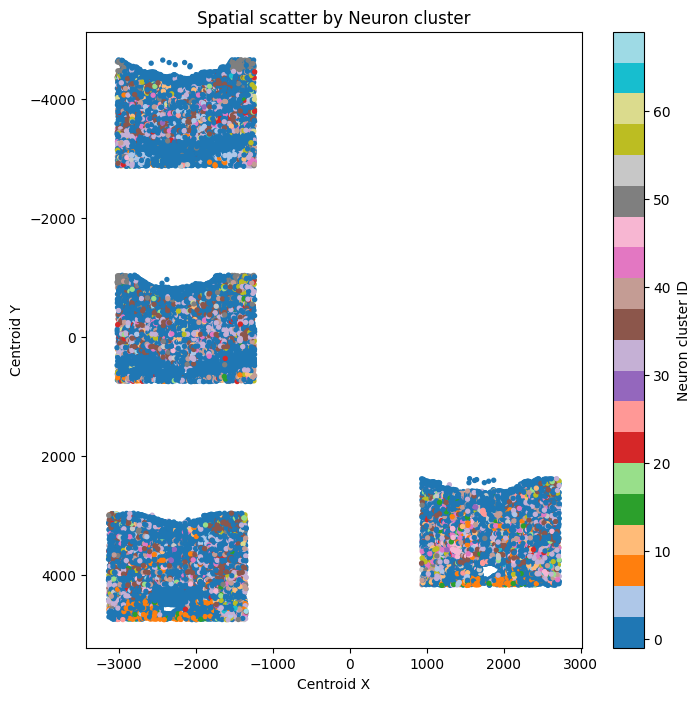

In [20]:
x = adata_st.obs['Centroid_X']
y = adata_st.obs['Centroid_Y']
if adata_st.obs['Neuron_cluster_ID'].dtype.name == 'category':
    c = adata_st.obs['Neuron_cluster_ID'].cat.codes
else:
    c = adata_st.obs['Neuron_cluster_ID']

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=c, cmap='tab20', s=8)
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Spatial scatter by Neuron cluster')
plt.gca().invert_yaxis()
plt.colorbar(label='Neuron cluster ID')
plt.show()


By looking at this plot, it seems like the data contains four slices of the same tissue sample spread over the plane for visualization. To subsample, we are going to subset the data based on the spatial coordinates to select a section of the full plane that contains only one slice, in this case the more compact one in the quadrant with $Centroid X < 0$ and $Centroid Y > 2000$:

In [21]:
adata_st = adata_st[(adata_st.obs['Centroid_X'] < 0) & (adata_st.obs['Centroid_Y'] > 2000)].copy()
adata_st

AnnData object with n_obs × n_vars = 5967 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    obsm: 'spatial'

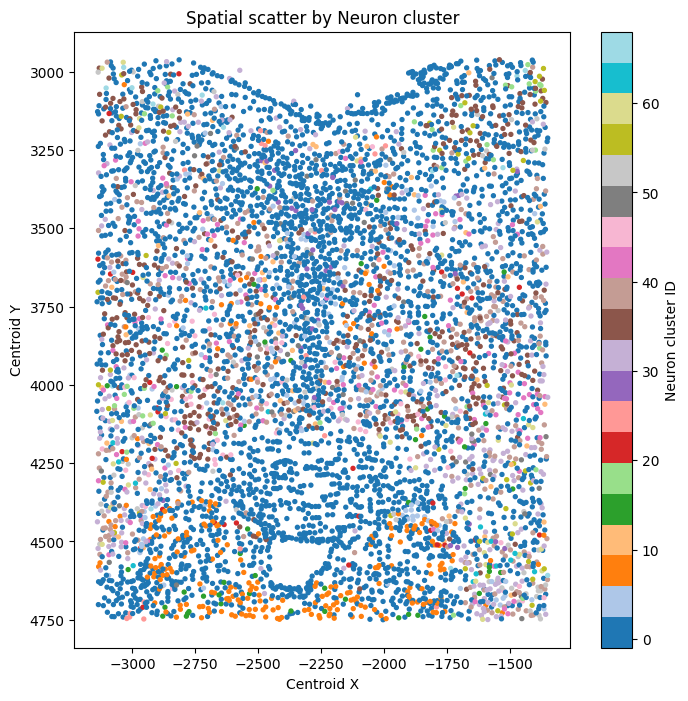

In [22]:
x = adata_st.obs['Centroid_X']
y = adata_st.obs['Centroid_Y']
if adata_st.obs['Neuron_cluster_ID'].dtype.name == 'category':
    c = adata_st.obs['Neuron_cluster_ID'].cat.codes
else:
    c = adata_st.obs['Neuron_cluster_ID']

plt.figure(figsize=(8,8))
plt.scatter(x, y, c=c, cmap='tab20', s=8)
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Spatial scatter by Neuron cluster')
plt.gca().invert_yaxis()
plt.colorbar(label='Neuron cluster ID')
plt.show()

#### Count format inspection

In [23]:
# Inspect basic stats
X = adata_st.X
if not isinstance(X, np.ndarray):
    X = X.toarray()  # if sparse

pd.Series(X.ravel()).describe()

count    924885.000000
mean          1.719035
std           6.168451
min           0.000000
25%           0.000000
50%           0.000000
75%           1.124222
max         250.767693
dtype: float64

In [24]:
# Check if all values are integers
is_integer = np.allclose(X, np.round(X))
print("All integer values:", is_integer)

All integer values: False


Counts do not appear to be raw, likely normalized:

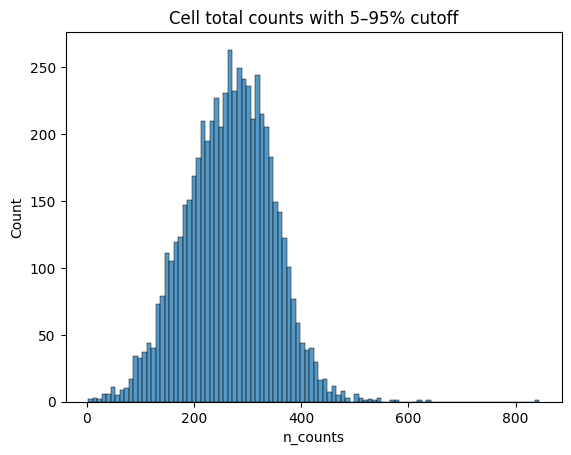

In [ ]:
# compute n counts per spot
adata_st.obs['n_counts'] = np.array(adata_st.X.sum(axis=1)).ravel()
sns.histplot(adata_st.obs['n_counts'], bins=100)
plt.title('Cell total counts')
plt.show()

This distribution is very Normal, bu not in log scale:

In [22]:
sc.pp.log1p(adata_st)

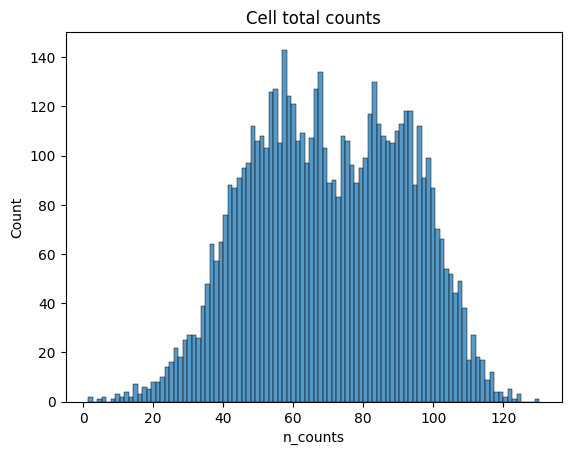

In [31]:
# compute n counts per spot
adata_st.obs['n_counts'] = np.array(adata_st.X.sum(axis=1)).ravel()
sns.histplot(adata_st.obs['n_counts'], bins=100)
plt.title('Cell total counts')
plt.show()

#### Empty cells

In [32]:
print("numebr of empty cells = ", (adata_st.X.sum(axis=1) == 0).sum())

numebr of empty cells =  0


#### Undetected genes

In [35]:
print("numebr of undetected genes = ", (adata_st.X.sum(axis=0) == 0).sum())

numebr of undetected genes =  0


#### Sparsity 

In [27]:
X = adata_st.X
if not isinstance(X, np.ndarray):
    X = X.copy()  # ensures .count_nonzero() works

# compute sparsity = fraction of zero entries
n_total = np.prod(adata_st.shape)
n_nonzero = X.count_nonzero() if hasattr(X, "count_nonzero") else np.count_nonzero(X)
sparsity = 1 - (n_nonzero / n_total)

adata_st.uns["sparsity"] = float(sparsity)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.6211


#### Spatial graph

In [28]:
sq.gr.spatial_neighbors(
    adata_st,
    coord_type='generic',   # 'visium' for Visium, 'generic' for single-cell resolution
    n_neighs=6,   
    set_diag=False,           # or adjust based on local cell density
    key_added="spatial"
)
adata_st

AnnData object with n_obs × n_vars = 5967 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells_expressed'
    uns: 'gearyC', 'moranI', 'sparsity', 'spatial_neighbors', 'log1p'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

#### SA statistics

In [29]:
# Moran’s I
sq.gr.spatial_autocorr(
    adata_st,
    connectivity_key="spatial_connectivities",
    mode="moran",
    transformation=True,
    show_progress_bar=True,
)

# Geary’s C
sq.gr.spatial_autocorr(
    adata_st,
    connectivity_key="spatial_connectivities",
    mode="geary",
    transformation=True,
    show_progress_bar=True,
)
adata_st

AnnData object with n_obs × n_vars = 5967 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells_expressed'
    uns: 'gearyC', 'moranI', 'sparsity', 'spatial_neighbors', 'log1p'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

#### Save

In [30]:
# Write h5ad
sc.write(data_path + "MERFISH_data.h5ad", adata_st, 'h5ad')

/tmp/ipykernel_1176341/3851524391.py:2: FutureWarning: The specified parameters ('ext',) are no longer positional. Please specify them like `ext='h5ad'`
  sc.write(data_path + "MERFISH_data.h5ad", adata_st, 'h5ad')


# Data loading

In [4]:
adata_st = sc.read(data_path + "spatial_data.h5ad")
adata_st

AnnData object with n_obs × n_vars = 5967 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells_expressed'
    uns: 'gearyC', 'log1p', 'moranI', 'sparsity', 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [5]:
adata_st.obs['Cell_class'].unique()

['Ambiguous', 'Inhibitory', 'OD Mature 3', 'OD Mature 2', 'Endothelial 1', ..., 'OD Immature 1', 'Pericytes', 'OD Mature 4', 'OD Immature 2', 'Ependymal']
Length: 16
Categories (16, object): ['Ambiguous', 'Astrocyte', 'Endothelial 1', 'Endothelial 2', ..., 'OD Mature 2', 'OD Mature 3', 'OD Mature 4', 'Pericytes']

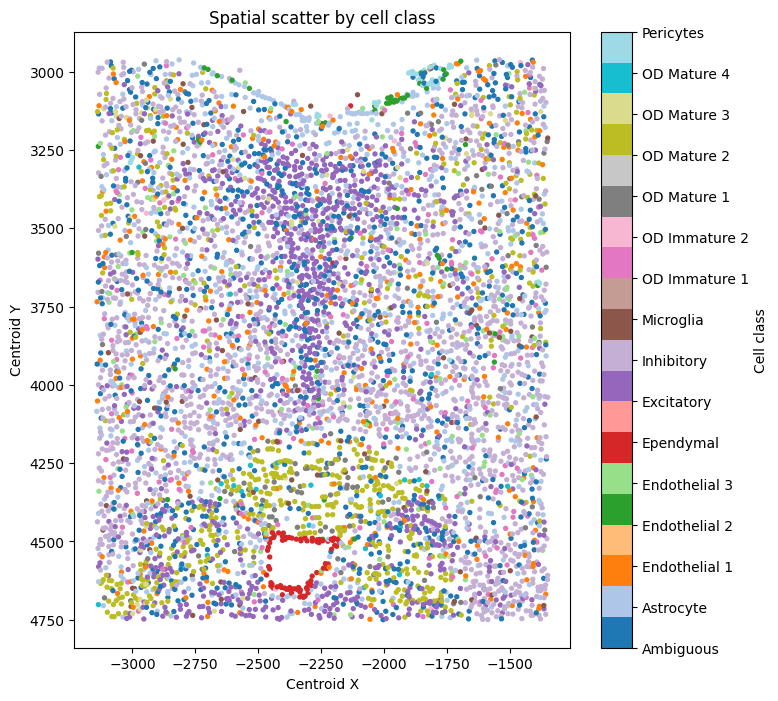

In [8]:
import matplotlib.pyplot as plt

x = adata_st.obs['Centroid_X']
y = adata_st.obs['Centroid_Y']

cell_class = adata_st.obs['Cell_class'].astype('category')
codes = cell_class.cat.codes

plt.figure(figsize=(8, 8))
sc = plt.scatter(
    x, y,
    c=codes,
    cmap='tab20',
    s=8
)

plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Spatial scatter by cell class')
plt.gca().invert_yaxis()

cbar = plt.colorbar(sc, ticks=range(len(cell_class.cat.categories)))
cbar.ax.set_yticklabels(cell_class.cat.categories)
cbar.set_label('Cell class')

plt.show()


In [5]:
adata_st.X.max()

np.float64(5.528506808374484)

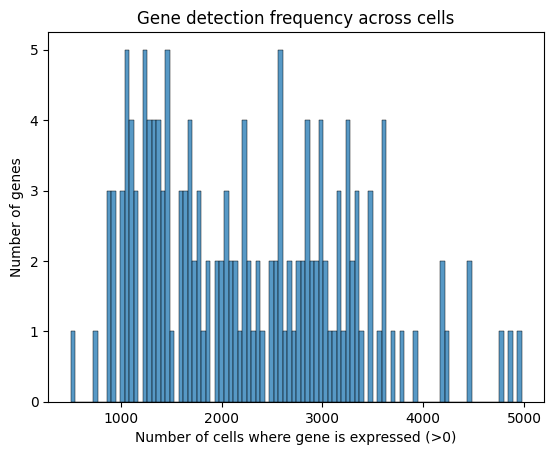

In [21]:
# compute counts if not already done
if 'n_cells_expressed' not in adata_st.var.columns:
    adata_st.var['n_cells_expressed'] = np.array((adata_st.X > 0).sum(axis=0)).ravel()

# histogram (log scale on x is clearer)
sns.histplot(adata_st.var['n_cells_expressed'], bins=100)
plt.xlabel('Number of cells where gene is expressed (>0)')
plt.ylabel('Number of genes')
plt.title('Gene detection frequency across cells')
plt.show()

Even here, most genes are expressed in a lot of cells, thus sparsity arises from per-cell distributions (there is at least a gene but many, or for each gene: it is expressed in a few cells but not in others).

In [24]:
X = adata_st.X
if not isinstance(X, np.ndarray):
    X = X.toarray()  # if sparse

pd.Series(X.ravel()).describe()

count    924885.000000
mean          0.452586
std           0.791546
min           0.000000
25%           0.000000
50%           0.000000
75%           0.753406
max           5.528507
dtype: float64

In [26]:
adata_st

AnnData object with n_obs × n_vars = 5967 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells_expressed'
    uns: 'gearyC', 'moranI', 'sparsity', 'spatial_neighbors', 'log1p'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'